<a href="https://colab.research.google.com/github/tangamy0976/colabratory/blob/main/Dict/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import sklearn.metrics as skm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D,MaxPooling1D
from google.colab import files
uploaded = files.upload()

def split_dataset(data):
    '''
    该函数实现以周为单位切分训练数据和测试数据
    '''
    # data为按天的耗电量统计数据，shape为(1442, 8)
    # 测试集取最后一年的46周（322天）数据，剩下的159周（1113天）数据为训练集，以下的切片实现此功能。
    train, test = data[1:-328], data[-328:-6]
    train = np.array(np.split(train, len(train)/7)) # 将数据划分为按周为单位的数据
    test = np.array(np.split(test, len(test)/7))
    return train, test

def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    scores = list()
    for i in range(actual.shape[1]):
        mse = skm.mean_squared_error(actual[:, i], predicted[:, i])
        rmse = math.sqrt(mse)
        scores.append(rmse)

    s = 0 # 计算总的 RMSE
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    print('actual.shape[0]:{}, actual.shape[1]:{}'.format(actual.shape[0], actual.shape[1]))
    return score, scores

def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s\n' % (name, score, s_scores))

def sliding_window(train, sw_width=7, n_out=7, in_start=0):
    '''
    该函数实现窗口宽度为7、滑动步长为1的滑动窗口截取序列数据
    截取所有特征
    '''
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2])) # 将以周为单位的样本展平为以天为单位的序列
    X, y = [], []

    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out

        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        if out_end < len(data):
            # 因为是for循环，所以滑动窗口的滑动步长为1；想调整滑动步长可以通过yield实现，后边的文章会讲；
            X.append(data[in_start:in_end, :]) # 截取窗口宽度数量的采样点的全部8个特征
            y.append(data[in_end:out_end, 0]) # 截取样本之后7个时间步长的总有功功耗（截取一个单列片段，有7个元素）
        in_start += 1

    return np.array(X), np.array(y)

def multi_input_cnn_model(train, sw_width, in_start=0, verbose=0, epochs=20, batch_size=16):
    '''
    该函数定义 多输入序列 CNN 模型
    '''
    train_x, train_y = sliding_window(train, sw_width, in_start=0)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu',
                     input_shape=(n_timesteps, n_features)))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(units=n_outputs))

    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    model.fit(train_x, train_y,
              epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


def forecast(model, pred_seq, sw_width):
    '''
    该函数实现对输入数据的预测
    多个特征
    '''
    data = np.array(pred_seq)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

    input_x = data[-sw_width:, :] # 获取输入数据的最后一周的数据
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) # 重塑形状为[1, sw_width, n]

    yhat = model.predict(input_x, verbose=0) # 预测下周数据
    yhat = yhat[0] # 获取预测向量
    return yhat

def evaluate_model(model, train, test, sd_width):
    '''
    该函数实现模型评估
    '''
    history_fore = [x for x in train]
    predictions = list() # 用于保存每周的前向验证结果；
    for i in range(len(test)):
        yhat_sequence = forecast(model, history_fore, sd_width) # 预测下周的数据
        predictions.append(yhat_sequence) # 保存预测结果
        history_fore.append(test[i, :]) # 得到真实的观察结果并添加到历史中以预测下周

    predictions = np.array(predictions) # 评估一周中每天的预测结果
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

def model_plot(score, scores, days, name):
    '''
    该函数实现绘制RMSE曲线图
    '''
    plt.figure(figsize=(8,6), dpi=150)
    plt.plot(days, scores, marker='o', label=name)
    plt.grid(linestyle='--', alpha=0.5)
    plt.ylabel(r'$RMSE$', size=15)
    plt.title('多输入序列 CNN 预测结果',  size=18)
    plt.legend()
    plt.show()

def main_run(dataset, sw_width, days, name, in_start, verbose, epochs, batch_size):
    '''
    主函数：数据处理、模型训练流程
    '''
    # 划分训练集和测试集
    train, test = split_dataset(dataset.values)
    # 训练模型
    model = multi_input_cnn_model(train, sw_width, in_start, verbose, epochs, batch_size)
    # 计算RMSE
    score, scores = evaluate_model(model, train, test, sw_width)
    # 打印分数
    summarize_scores(name, score, scores)
    # 绘图
    model_plot(score, scores, days, name)

if __name__ == '__main__':

    # parse_dates可以合并原来数据中的时间序列，index_col是指定datetime为索引列
    dataset = pd.read_csv('household_power_consumption_days.csv', header=0,
                   infer_datetime_format=True, engine='c',
                   parse_dates=['datetime'], index_col=['datetime'])

    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
    name = 'cnn'

    sliding_window_width=14
    input_sequence_start=0

    epochs_num=80
    batch_size_set=16
    verbose_set=0


    main_run(dataset, sliding_window_width, days, name, input_sequence_start,
             verbose_set, epochs_num, batch_size_set)


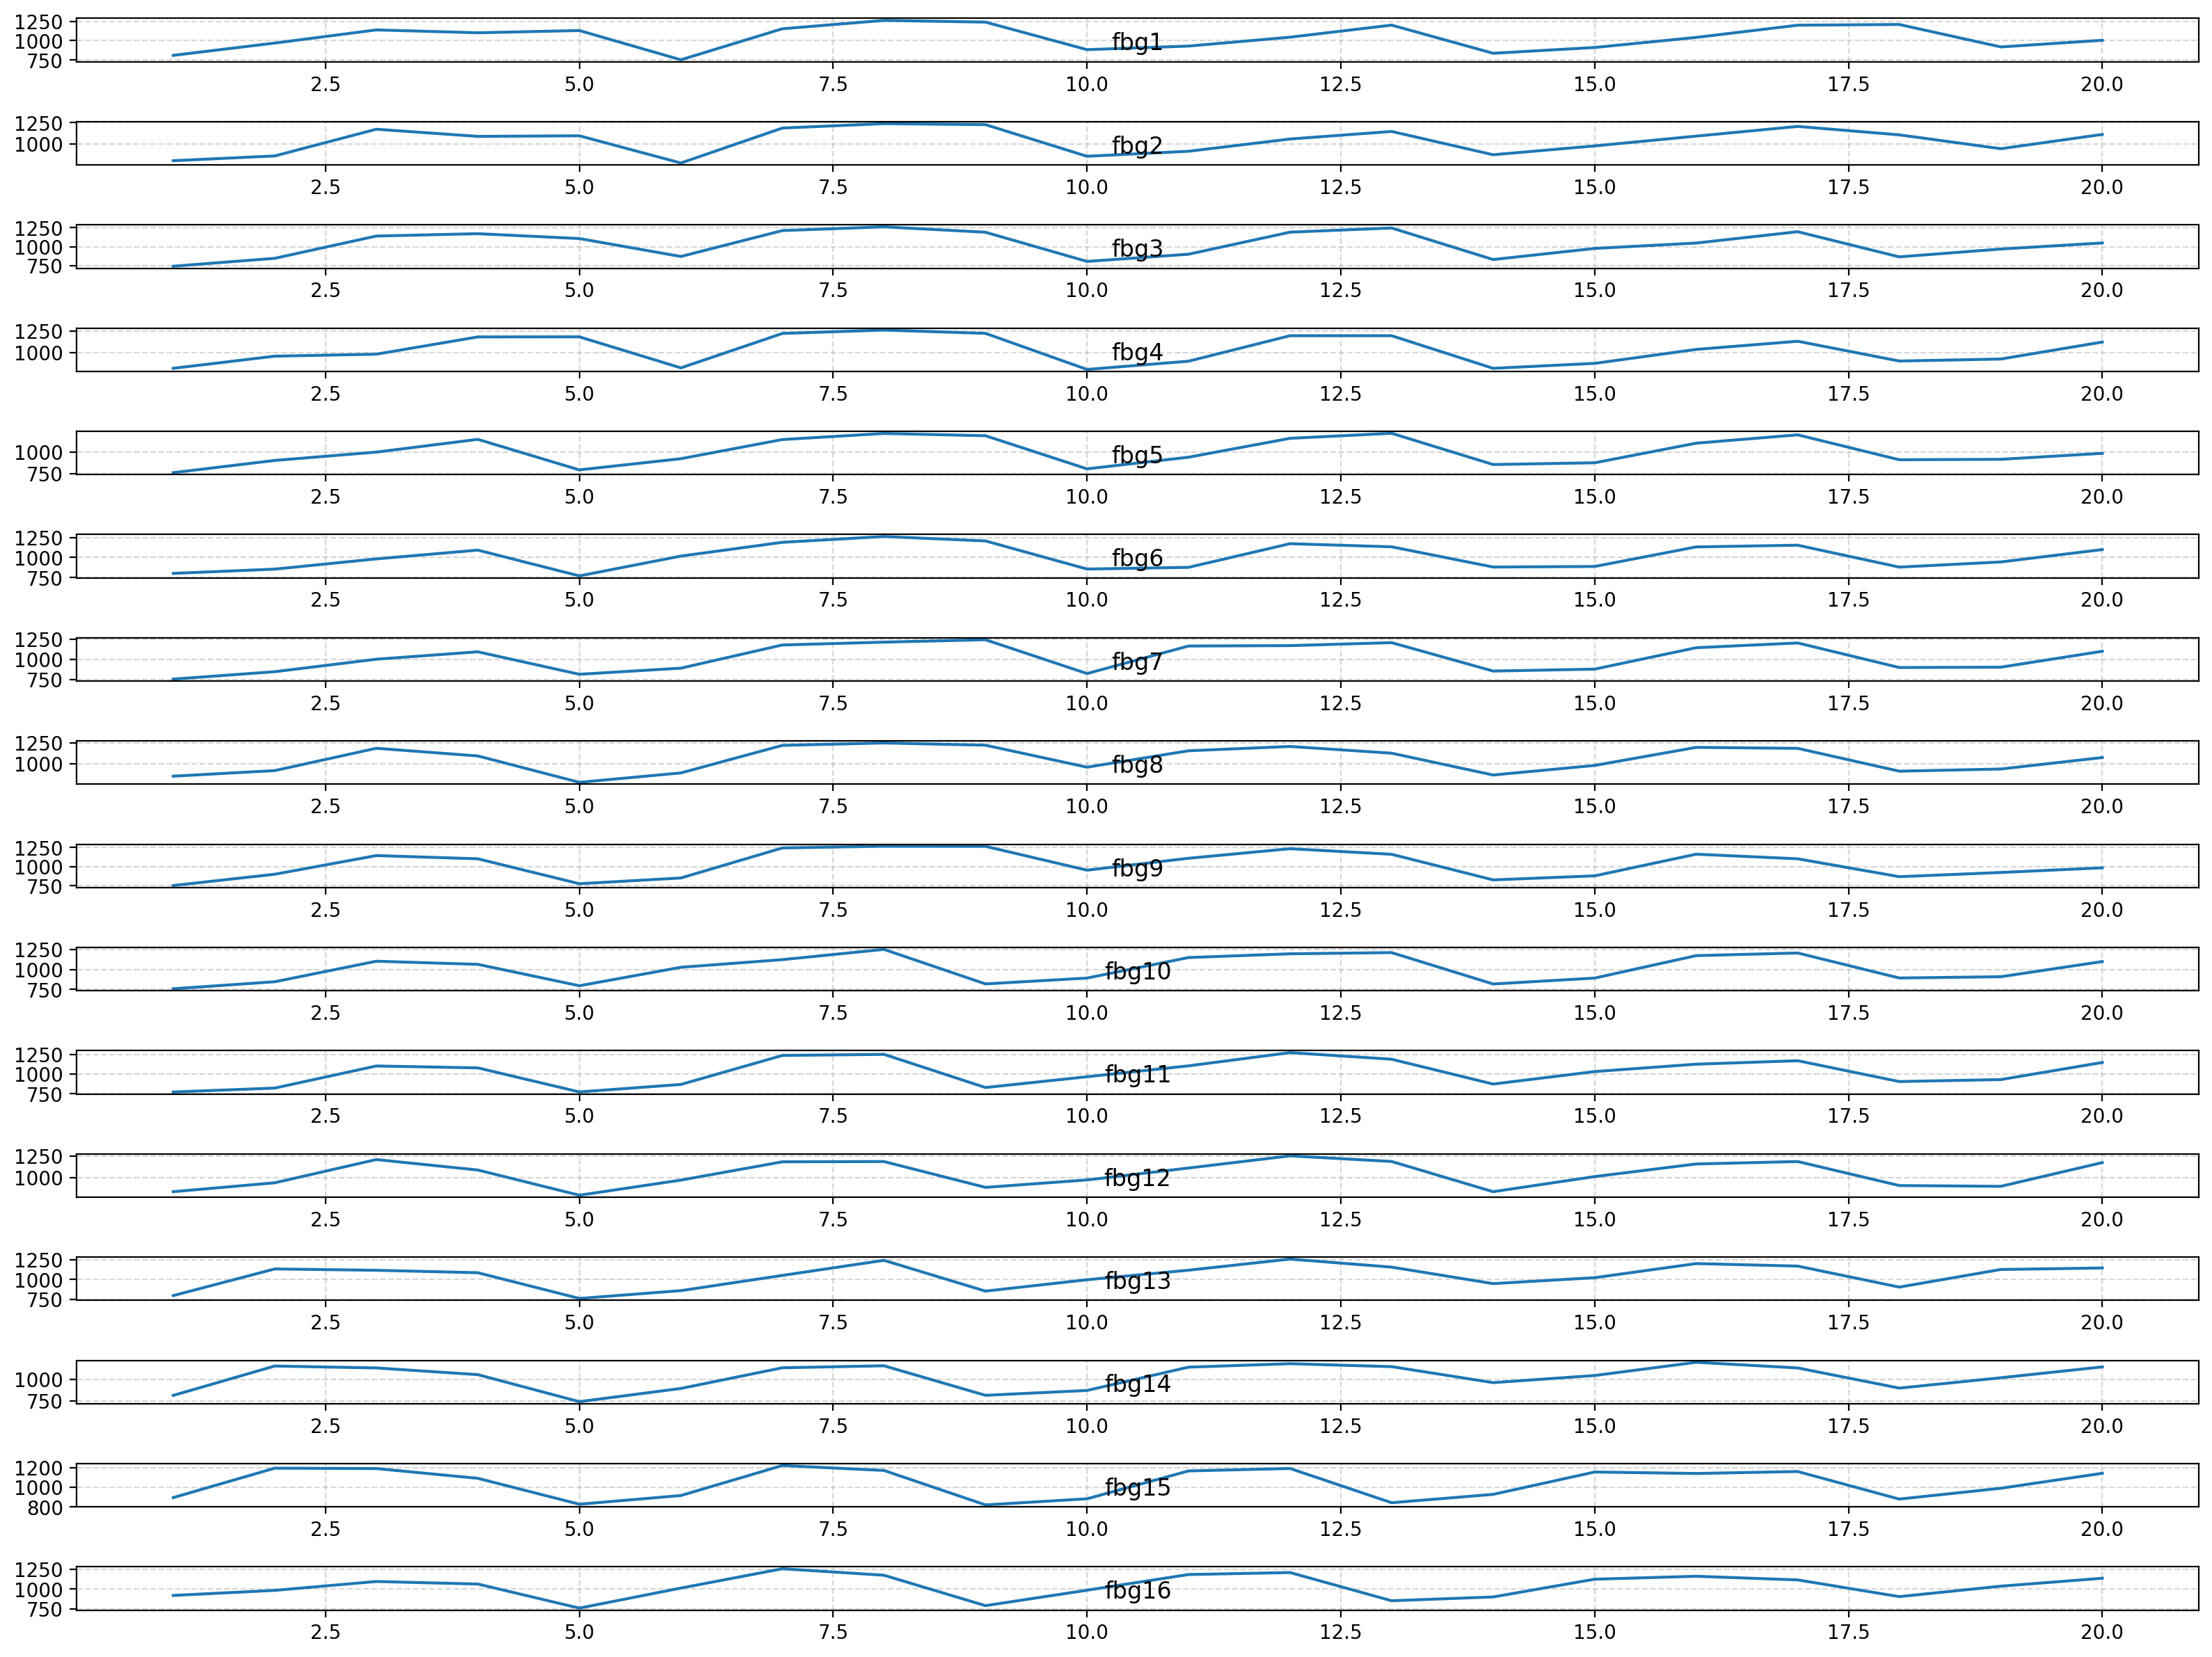

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv('/content/fbg_data.csv', header=0,
                   infer_datetime_format=True, engine='c',
                  index_col=['category'])
def plot_features(dataset):
    plt.figure(figsize=(16,12), dpi=200)
    for i in range(len(dataset.columns)):
        plt.subplot(len(dataset.columns), 1, i+1)
        feature_name = dataset.columns[i]
        plt.plot(dataset[feature_name])
        plt.title(feature_name, y=0)
        plt.grid(linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_features(dataset)
